## Importing additional Python libraries<a class="anchor" id="1"></a>
<!-- <mark>[Return Contents](#0) -->

In [1]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

## Importing Dataset and preprocessing <a class="anchor" id="2"></a>
<mark>[Return Contents](#0)

In [3]:
path = ('....xlsx')
xl = pd.ExcelFile(path)
df = xl.parse('Sheet1')
# df.head()

In [4]:
path_meh = '....csv'
df_meh = pd.read_csv(path_meh)
df_meh = df_meh.drop(df_meh.columns[0], axis=1)
# df_meh

In [16]:
df.shape

(1073, 14)

In [17]:
print(df.columns.tolist()) # column names

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'TEXT_whole_doc', 'document structure', 'TEXT_in_doc_structure', 'mention', 'UMLS with desc', 'ORDO with desc', 'gold mention-to-UMLS label', 'gold UMLS-to-ORDO label', 'gold mention-to-ORDO label']


In [18]:
df.dtypes

ROW_ID                         int64
SUBJECT_ID                     int64
HADM_ID                        int64
CATEGORY                      object
DESCRIPTION                   object
TEXT_whole_doc                object
document structure            object
TEXT_in_doc_structure         object
mention                       object
UMLS with desc                object
ORDO with desc                object
gold mention-to-UMLS label     int64
gold UMLS-to-ORDO label        int64
gold mention-to-ORDO label     int64
dtype: object

In [19]:
df['document structure'].value_counts()

Hospital_course                         359
History_of_Past_Illness                 171
History_of_Present_Illness              139
pertinent_results                        64
Discharge_Diagnosis                      58
Discharge_Medications                    54
Admission_Medications                    49
basic                                    36
Hospital_Discharge_Physical              30
Review_of_Systems                        18
Chief_Complaint_and_Reason_for_Visit     15
facility                                 14
Social_History                           11
Hospital_Discharge_Studies                9
Procedures                                9
Hospital_Discharge_Instructions           8
interpretation                            7
impression                                5
admission_studies                         5
Problem                                   4
Immunizations                             2
Nutrition                                 2
Family_History                  

### Data cleaning <a class="anchor" id="2_1"></a>

In [20]:
df.isnull().any()

ROW_ID                        False
SUBJECT_ID                    False
HADM_ID                       False
CATEGORY                      False
DESCRIPTION                   False
TEXT_whole_doc                False
document structure            False
TEXT_in_doc_structure         False
mention                       False
UMLS with desc                False
ORDO with desc                False
gold mention-to-UMLS label    False
gold UMLS-to-ORDO label       False
gold mention-to-ORDO label    False
dtype: bool

Class lable : `gold mention-to-UMLS label`: Check whether the matching is correct from the mention to the UMLS concept, 1 if correct, 0 if not.

In [21]:
df['gold mention-to-UMLS label'].value_counts() # 1 incorrect data for 'gold mention-to-UMLS label'

 0    743
 1    329
-1      1
Name: gold mention-to-UMLS label, dtype: int64

In [22]:
df.drop(df[df['gold mention-to-UMLS label'] == -1].index, inplace=True) # delete unexpected data

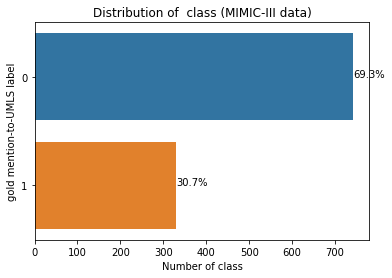

In [23]:
ax = sns.countplot(y="gold mention-to-UMLS label", data=df)
plt.title('Distribution of  class (MIMIC-III data)')
plt.xlabel('Number of class')
total = len(df['gold mention-to-UMLS label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

## Generation of training and testing set<a class="anchor" id="6"></a>
<!-- <mark>[Return Contents](#0) -->

In [24]:
texts = df['mention'].tolist()
labels = df['gold mention-to-UMLS label'].tolist()
texts_meh = df_meh['str'].tolist()
labels_meh = df_meh['label'].tolist()

In [25]:
X_test, y_test = texts_meh, labels_meh
X_train, X_dev, y_train, y_dev = train_test_split(texts,
                                                  labels,
                                                  test_size=0.25,
                                                  train_size=0.75,
                                                  random_state=seed)
# len(X_train), len(y_train), len(X_test), len(y_test), len(X_dev), len(y_dev)
print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))

Train size: 804
Dev size: 268
Test size: 447


## Classification algorithm 1: BERT<a class="anchor" id="7"></a>
<!-- <mark>[Return Contents](#0) -->

### Loading pre-trained models<a class="anchor" id="7_1"></a>
Model from huggingface: https://huggingface.co/models

In [26]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Loading data for training and testing<a class="anchor" id="7_1"></a>

In [27]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

### Define hyperparameters<a class="anchor" id="7_3"></a>

In [28]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

### Create a dataloader instance<a class="anchor" id="7_4"></a>

In [29]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

### Define BERT model<a class="anchor" id="7_5"></a>
- BERT pretrained model
- one feedforward layer

In [30]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

### Evaluation function<a class="anchor" id="7_6"></a>

In [31]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

### Training function<a class="anchor" id="7_6"></a>

In [32]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

### Identify CPU/GPU device for training<a class="anchor" id="7_8"></a>

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [36]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

### Train the model<a class="anchor" id="7_9"></a>

In [37]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 161/161 [00:05<00:00, 28.22it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.09it/s]


Training Loss: 0.397 dev performance, p:0.972, r:0.841, f1:0.902
current best score is 0.902

 Epoch 2 / 20



100%|██████████| 161/161 [00:05<00:00, 28.19it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.96it/s]


Training Loss: 0.297 dev performance, p:0.973, r:0.878, f1:0.923
current best score is 0.923

 Epoch 3 / 20



100%|██████████| 161/161 [00:06<00:00, 26.22it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.27it/s]


Training Loss: 0.244 dev performance, p:0.918, r:0.951, f1:0.934
current best score is 0.934

 Epoch 4 / 20



100%|██████████| 161/161 [00:05<00:00, 29.80it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.95it/s]


Training Loss: 0.182 dev performance, p:0.942, r:0.988, f1:0.964
current best score is 0.964

 Epoch 5 / 20



100%|██████████| 161/161 [00:05<00:00, 29.08it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.33it/s]


Training Loss: 0.176 dev performance, p:0.940, r:0.963, f1:0.952

 Epoch 6 / 20



100%|██████████| 161/161 [00:05<00:00, 30.12it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.38it/s]


Training Loss: 0.152 dev performance, p:0.975, r:0.939, f1:0.957

 Epoch 7 / 20



100%|██████████| 161/161 [00:05<00:00, 30.52it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.42it/s]


Training Loss: 0.153 dev performance, p:0.975, r:0.951, f1:0.963

 Epoch 8 / 20



100%|██████████| 161/161 [00:05<00:00, 30.29it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.33it/s]


Training Loss: 0.153 dev performance, p:0.940, r:0.951, f1:0.945

 Epoch 9 / 20



100%|██████████| 161/161 [00:05<00:00, 29.55it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.43it/s]


Training Loss: 0.142 dev performance, p:0.975, r:0.951, f1:0.963

 Epoch 10 / 20



100%|██████████| 161/161 [00:05<00:00, 30.08it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.63it/s]


Training Loss: 0.130 dev performance, p:0.975, r:0.951, f1:0.963

 Epoch 11 / 20



100%|██████████| 161/161 [00:05<00:00, 30.82it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.83it/s]


Training Loss: 0.136 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 12 / 20



100%|██████████| 161/161 [00:05<00:00, 29.67it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.55it/s]


Training Loss: 0.141 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 13 / 20



100%|██████████| 161/161 [00:05<00:00, 30.47it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.50it/s]


Training Loss: 0.124 dev performance, p:0.940, r:0.951, f1:0.945

 Epoch 14 / 20



100%|██████████| 161/161 [00:05<00:00, 28.79it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.30it/s]


Training Loss: 0.128 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 15 / 20



100%|██████████| 161/161 [00:05<00:00, 27.60it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.16it/s]


Training Loss: 0.139 dev performance, p:0.939, r:0.939, f1:0.939

 Epoch 16 / 20



100%|██████████| 161/161 [00:06<00:00, 24.65it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 96.86it/s]


Training Loss: 0.121 dev performance, p:0.987, r:0.951, f1:0.969
current best score is 0.969

 Epoch 17 / 20



100%|██████████| 161/161 [00:05<00:00, 29.63it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.92it/s]


Training Loss: 0.115 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 18 / 20



100%|██████████| 161/161 [00:05<00:00, 29.45it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.54it/s]


Training Loss: 0.116 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 19 / 20



100%|██████████| 161/161 [00:05<00:00, 30.46it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.91it/s]


Training Loss: 0.114 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 20 / 20



100%|██████████| 161/161 [00:05<00:00, 28.81it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.39it/s]


Training Loss: 0.107 dev performance, p:0.975, r:0.951, f1:0.963


### Save the model<a class="anchor" id="7_10"></a>

In [38]:
model_file = 'bert_initial_meh_validation.pt'
torch.save(best_model_state, model_file)

In [39]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_initial_meh_validation.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the model<a class="anchor" id="7_11"></a>

In [40]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [41]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 90/90 [00:00<00:00, 112.74it/s]

{'precision': 0.9278350515463918, 'recall': 0.7584269662921348, 'f1': 0.8346213292117465}


In [42]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.48      0.82      0.60        91
           1       0.94      0.77      0.85       356

    accuracy                           0.78       447
   macro avg       0.71      0.80      0.73       447
weighted avg       0.85      0.78      0.80       447



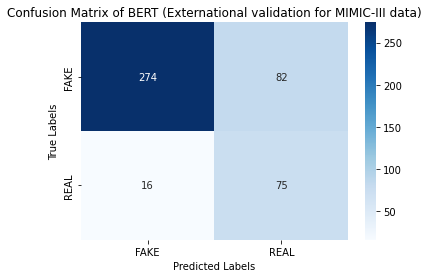

In [43]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT (Externational validation for MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_bert_meh_validation')

### Fine-tune hyperparameters<a class="anchor" id="7_12"></a>

In [44]:
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [45]:
# # %%time
# # from bert import run_classifier
# params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# # wrap classifier/regressor in GridSearchCV
# clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
#                    params,
#                    cv=3,
#                    scoring='accuracy',
#                    verbose=True)

# # fit gridsearch 
# clf_bert.fit(X_train ,y_train)

In [46]:
# means = clf_bert.cv_results_['mean_test_score']
# stds = clf_bert.cv_results_['std_test_score']

# for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
        
# # best scores
# print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

In [6]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)
# Print state of GPU
# !nvidia-smi

In [48]:
#define a batch size
batch_size = 5
epochs = 75
learning_rate = 1e-5

In [50]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [51]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 75


100%|██████████| 161/161 [00:06<00:00, 26.51it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.18it/s]


Training Loss: 0.802 dev performance, p:0.027, r:0.061, f1:0.038
current best score is 0.038

 Epoch 2 / 75



100%|██████████| 161/161 [00:05<00:00, 28.02it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 106.77it/s]


Training Loss: 0.796 dev performance, p:0.006, r:0.012, f1:0.008

 Epoch 3 / 75



100%|██████████| 161/161 [00:06<00:00, 24.58it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.41it/s]


Training Loss: 0.789 dev performance, p:0.018, r:0.037, f1:0.024

 Epoch 4 / 75



100%|██████████| 161/161 [00:05<00:00, 28.31it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.08it/s]


Training Loss: 0.778 dev performance, p:0.043, r:0.085, f1:0.057
current best score is 0.057

 Epoch 5 / 75



100%|██████████| 161/161 [00:05<00:00, 28.29it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.96it/s]


Training Loss: 0.771 dev performance, p:0.043, r:0.085, f1:0.057
current best score is 0.057

 Epoch 6 / 75



100%|██████████| 161/161 [00:05<00:00, 29.13it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.00it/s]


Training Loss: 0.764 dev performance, p:0.029, r:0.049, f1:0.037

 Epoch 7 / 75



100%|██████████| 161/161 [00:05<00:00, 29.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.62it/s]


Training Loss: 0.755 dev performance, p:0.048, r:0.073, f1:0.058
current best score is 0.058

 Epoch 8 / 75



100%|██████████| 161/161 [00:05<00:00, 28.61it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.09it/s]


Training Loss: 0.746 dev performance, p:0.053, r:0.073, f1:0.062
current best score is 0.062

 Epoch 9 / 75



100%|██████████| 161/161 [00:05<00:00, 29.35it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.57it/s]


Training Loss: 0.741 dev performance, p:0.066, r:0.073, f1:0.069
current best score is 0.069

 Epoch 10 / 75



100%|██████████| 161/161 [00:05<00:00, 26.97it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.01it/s]


Training Loss: 0.732 dev performance, p:0.115, r:0.110, f1:0.113
current best score is 0.113

 Epoch 11 / 75



100%|██████████| 161/161 [00:05<00:00, 26.88it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.08it/s]


Training Loss: 0.727 dev performance, p:0.066, r:0.049, f1:0.056

 Epoch 12 / 75



100%|██████████| 161/161 [00:05<00:00, 29.33it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.63it/s]


Training Loss: 0.718 dev performance, p:0.140, r:0.085, f1:0.106

 Epoch 13 / 75



100%|██████████| 161/161 [00:05<00:00, 29.26it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.05it/s]


Training Loss: 0.711 dev performance, p:0.238, r:0.122, f1:0.161
current best score is 0.161

 Epoch 14 / 75



100%|██████████| 161/161 [00:05<00:00, 29.48it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.02it/s]


Training Loss: 0.706 dev performance, p:0.294, r:0.122, f1:0.172
current best score is 0.172

 Epoch 15 / 75



100%|██████████| 161/161 [00:05<00:00, 29.49it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.57it/s]


Training Loss: 0.696 dev performance, p:0.370, r:0.122, f1:0.183
current best score is 0.183

 Epoch 16 / 75



100%|██████████| 161/161 [00:05<00:00, 28.89it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.12it/s]


Training Loss: 0.690 dev performance, p:0.400, r:0.098, f1:0.157

 Epoch 17 / 75



100%|██████████| 161/161 [00:05<00:00, 29.26it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.16it/s]


Training Loss: 0.684 dev performance, p:0.769, r:0.122, f1:0.211
current best score is 0.211

 Epoch 18 / 75



100%|██████████| 161/161 [00:05<00:00, 28.82it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.10it/s]


Training Loss: 0.674 dev performance, p:0.769, r:0.122, f1:0.211

 Epoch 19 / 75



100%|██████████| 161/161 [00:05<00:00, 27.84it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.21it/s]


Training Loss: 0.669 dev performance, p:0.786, r:0.134, f1:0.229
current best score is 0.229

 Epoch 20 / 75



100%|██████████| 161/161 [00:05<00:00, 29.39it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.78it/s]


Training Loss: 0.661 dev performance, p:1.000, r:0.146, f1:0.255
current best score is 0.255

 Epoch 21 / 75



100%|██████████| 161/161 [00:05<00:00, 29.36it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.08it/s]


Training Loss: 0.655 dev performance, p:0.933, r:0.171, f1:0.289
current best score is 0.289

 Epoch 22 / 75



100%|██████████| 161/161 [00:05<00:00, 29.20it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.87it/s]


Training Loss: 0.650 dev performance, p:0.933, r:0.171, f1:0.289

 Epoch 23 / 75



100%|██████████| 161/161 [00:05<00:00, 29.35it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.06it/s]


Training Loss: 0.641 dev performance, p:0.929, r:0.159, f1:0.271

 Epoch 24 / 75



100%|██████████| 161/161 [00:05<00:00, 26.96it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.32it/s]


Training Loss: 0.633 dev performance, p:1.000, r:0.159, f1:0.274

 Epoch 25 / 75



100%|██████████| 161/161 [00:06<00:00, 26.33it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.30it/s]


Training Loss: 0.628 dev performance, p:1.000, r:0.122, f1:0.217

 Epoch 26 / 75



100%|██████████| 161/161 [00:06<00:00, 25.73it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.31it/s]


Training Loss: 0.620 dev performance, p:1.000, r:0.232, f1:0.376
current best score is 0.376

 Epoch 27 / 75



100%|██████████| 161/161 [00:06<00:00, 25.40it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.05it/s]


Training Loss: 0.616 dev performance, p:0.882, r:0.183, f1:0.303

 Epoch 28 / 75



100%|██████████| 161/161 [00:06<00:00, 26.49it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.99it/s]


Training Loss: 0.611 dev performance, p:0.895, r:0.207, f1:0.337

 Epoch 29 / 75



100%|██████████| 161/161 [00:06<00:00, 25.57it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.73it/s]


Training Loss: 0.602 dev performance, p:0.913, r:0.256, f1:0.400
current best score is 0.400

 Epoch 30 / 75



100%|██████████| 161/161 [00:06<00:00, 24.23it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.72it/s]


Training Loss: 0.595 dev performance, p:0.926, r:0.305, f1:0.459
current best score is 0.459

 Epoch 31 / 75



100%|██████████| 161/161 [00:06<00:00, 26.60it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.21it/s]


Training Loss: 0.588 dev performance, p:0.938, r:0.183, f1:0.306

 Epoch 32 / 75



100%|██████████| 161/161 [00:05<00:00, 28.17it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.36it/s]


Training Loss: 0.586 dev performance, p:0.944, r:0.207, f1:0.340

 Epoch 33 / 75



100%|██████████| 161/161 [00:06<00:00, 25.18it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 88.99it/s]


Training Loss: 0.578 dev performance, p:1.000, r:0.232, f1:0.376

 Epoch 34 / 75



100%|██████████| 161/161 [00:06<00:00, 24.86it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.96it/s]


Training Loss: 0.573 dev performance, p:0.905, r:0.232, f1:0.369

 Epoch 35 / 75



100%|██████████| 161/161 [00:06<00:00, 24.79it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.69it/s]


Training Loss: 0.565 dev performance, p:0.958, r:0.280, f1:0.434

 Epoch 36 / 75



100%|██████████| 161/161 [00:06<00:00, 25.03it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.36it/s]


Training Loss: 0.561 dev performance, p:0.923, r:0.293, f1:0.444

 Epoch 37 / 75



100%|██████████| 161/161 [00:05<00:00, 28.29it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.58it/s]


Training Loss: 0.555 dev performance, p:0.933, r:0.341, f1:0.500
current best score is 0.500

 Epoch 38 / 75



100%|██████████| 161/161 [00:05<00:00, 29.24it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.25it/s]


Training Loss: 0.549 dev performance, p:0.967, r:0.354, f1:0.518
current best score is 0.518

 Epoch 39 / 75



100%|██████████| 161/161 [00:05<00:00, 29.38it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.20it/s]


Training Loss: 0.546 dev performance, p:1.000, r:0.390, f1:0.561
current best score is 0.561

 Epoch 40 / 75



100%|██████████| 161/161 [00:06<00:00, 24.34it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.01it/s]


Training Loss: 0.537 dev performance, p:0.938, r:0.366, f1:0.526

 Epoch 41 / 75



100%|██████████| 161/161 [00:06<00:00, 26.22it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.43it/s]


Training Loss: 0.531 dev performance, p:0.969, r:0.378, f1:0.544

 Epoch 42 / 75



100%|██████████| 161/161 [00:06<00:00, 25.94it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.22it/s]


Training Loss: 0.526 dev performance, p:0.938, r:0.366, f1:0.526

 Epoch 43 / 75



100%|██████████| 161/161 [00:05<00:00, 29.31it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.91it/s]


Training Loss: 0.524 dev performance, p:0.968, r:0.366, f1:0.531

 Epoch 44 / 75



100%|██████████| 161/161 [00:05<00:00, 29.62it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.46it/s]


Training Loss: 0.516 dev performance, p:0.951, r:0.476, f1:0.634


current best score is 0.634

 Epoch 45 / 75


100%|██████████| 161/161 [00:05<00:00, 27.68it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.01it/s]


Training Loss: 0.511 dev performance, p:1.000, r:0.476, f1:0.645
current best score is 0.645

 Epoch 46 / 75



100%|██████████| 161/161 [00:05<00:00, 28.76it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.87it/s]


Training Loss: 0.505 dev performance, p:1.000, r:0.512, f1:0.677
current best score is 0.677

 Epoch 47 / 75



100%|██████████| 161/161 [00:05<00:00, 27.97it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.87it/s]


Training Loss: 0.500 dev performance, p:0.976, r:0.500, f1:0.661

 Epoch 48 / 75



100%|██████████| 161/161 [00:06<00:00, 26.65it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.52it/s]


Training Loss: 0.495 dev performance, p:0.977, r:0.512, f1:0.672

 Epoch 49 / 75



100%|██████████| 161/161 [00:05<00:00, 28.40it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.73it/s]


Training Loss: 0.491 dev performance, p:0.956, r:0.524, f1:0.677

 Epoch 50 / 75



100%|██████████| 161/161 [00:05<00:00, 29.39it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.45it/s]


Training Loss: 0.486 dev performance, p:0.959, r:0.573, f1:0.718
current best score is 0.718

 Epoch 51 / 75



100%|██████████| 161/161 [00:05<00:00, 29.45it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.88it/s]


Training Loss: 0.478 dev performance, p:0.961, r:0.598, f1:0.737
current best score is 0.737

 Epoch 52 / 75



100%|██████████| 161/161 [00:05<00:00, 28.97it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.95it/s]


Training Loss: 0.476 dev performance, p:1.000, r:0.598, f1:0.748
current best score is 0.748

 Epoch 53 / 75



100%|██████████| 161/161 [00:05<00:00, 29.49it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.63it/s]


Training Loss: 0.471 dev performance, p:0.981, r:0.634, f1:0.770
current best score is 0.770

 Epoch 54 / 75



100%|██████████| 161/161 [00:05<00:00, 29.30it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.35it/s]


Training Loss: 0.466 dev performance, p:0.967, r:0.720, f1:0.825
current best score is 0.825

 Epoch 55 / 75



100%|██████████| 161/161 [00:05<00:00, 29.44it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.89it/s]


Training Loss: 0.462 dev performance, p:0.966, r:0.683, f1:0.800

 Epoch 56 / 75



100%|██████████| 161/161 [00:05<00:00, 29.23it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.97it/s]


Training Loss: 0.456 dev performance, p:0.984, r:0.756, f1:0.855
current best score is 0.855

 Epoch 57 / 75



100%|██████████| 161/161 [00:05<00:00, 27.90it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.19it/s]


Training Loss: 0.451 dev performance, p:0.985, r:0.793, f1:0.878
current best score is 0.878

 Epoch 58 / 75



100%|██████████| 161/161 [00:06<00:00, 24.82it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.34it/s]


Training Loss: 0.446 dev performance, p:0.983, r:0.720, f1:0.831

 Epoch 59 / 75



100%|██████████| 161/161 [00:06<00:00, 23.75it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 89.52it/s]


Training Loss: 0.444 dev performance, p:0.985, r:0.793, f1:0.878

 Epoch 60 / 75



100%|██████████| 161/161 [00:06<00:00, 24.65it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 88.64it/s]


Training Loss: 0.438 dev performance, p:0.971, r:0.829, f1:0.895
current best score is 0.895

 Epoch 61 / 75



100%|██████████| 161/161 [00:06<00:00, 24.32it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 87.94it/s]


Training Loss: 0.435 dev performance, p:0.957, r:0.805, f1:0.874

 Epoch 62 / 75



100%|██████████| 161/161 [00:06<00:00, 23.95it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 91.42it/s]


Training Loss: 0.429 dev performance, p:0.986, r:0.841, f1:0.908
current best score is 0.908

 Epoch 63 / 75



100%|██████████| 161/161 [00:05<00:00, 27.04it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.96it/s]


Training Loss: 0.425 dev performance, p:0.986, r:0.854, f1:0.915
current best score is 0.915

 Epoch 64 / 75



100%|██████████| 161/161 [00:05<00:00, 29.46it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.06it/s]


Training Loss: 0.423 dev performance, p:0.973, r:0.866, f1:0.916
current best score is 0.916

 Epoch 65 / 75



100%|██████████| 161/161 [00:05<00:00, 29.49it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.72it/s]


Training Loss: 0.416 dev performance, p:0.986, r:0.890, f1:0.936
current best score is 0.936

 Epoch 66 / 75



100%|██████████| 161/161 [00:05<00:00, 29.30it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.57it/s]


Training Loss: 0.415 dev performance, p:0.974, r:0.902, f1:0.937
current best score is 0.937

 Epoch 67 / 75



100%|██████████| 161/161 [00:05<00:00, 29.02it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.42it/s]


Training Loss: 0.408 dev performance, p:0.987, r:0.902, f1:0.943
current best score is 0.943

 Epoch 68 / 75



100%|██████████| 161/161 [00:06<00:00, 25.43it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 85.67it/s]


Training Loss: 0.406 dev performance, p:0.974, r:0.902, f1:0.937

 Epoch 69 / 75



100%|██████████| 161/161 [00:05<00:00, 28.51it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.98it/s]


Training Loss: 0.402 dev performance, p:0.974, r:0.915, f1:0.943
current best score is 0.943

 Epoch 70 / 75



100%|██████████| 161/161 [00:05<00:00, 29.14it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.73it/s]


Training Loss: 0.400 dev performance, p:0.975, r:0.951, f1:0.963
current best score is 0.963

 Epoch 71 / 75



100%|██████████| 161/161 [00:05<00:00, 29.55it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.82it/s]


Training Loss: 0.393 dev performance, p:0.975, r:0.939, f1:0.957

 Epoch 72 / 75



100%|██████████| 161/161 [00:05<00:00, 29.46it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.26it/s]


Training Loss: 0.389 dev performance, p:0.974, r:0.927, f1:0.950

 Epoch 73 / 75



100%|██████████| 161/161 [00:05<00:00, 29.33it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.97it/s]


Training Loss: 0.388 dev performance, p:0.975, r:0.939, f1:0.957

 Epoch 74 / 75



100%|██████████| 161/161 [00:06<00:00, 25.42it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 91.67it/s]


Training Loss: 0.382 dev performance, p:0.987, r:0.951, f1:0.969
current best score is 0.969

 Epoch 75 / 75



100%|██████████| 161/161 [00:06<00:00, 24.80it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.52it/s]


Training Loss: 0.380 dev performance, p:0.987, r:0.939, f1:0.963


In [52]:
model_file = 'bert_gridsearch_meh_validation.pt'
torch.save(best_model_state, model_file)

In [53]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_gridsearch_meh_validation.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BERT

In [54]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [55]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 90/90 [00:01<00:00, 86.86it/s]

{'precision': 0.9616858237547893, 'recall': 0.7050561797752809, 'f1': 0.813614262560778}


In [56]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.43      0.85      0.57        91
           1       0.95      0.72      0.82       356

    accuracy                           0.74       447
   macro avg       0.69      0.78      0.69       447
weighted avg       0.84      0.74      0.77       447



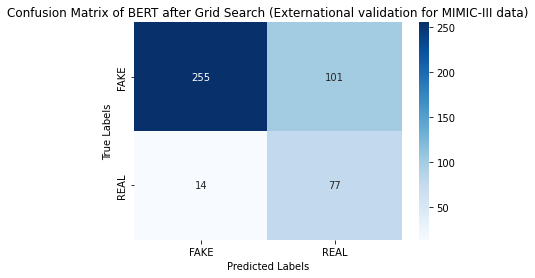

In [57]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT after Grid Search (Externational validation for MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BERT(grid search)')

## Classification algorithm 2: BlueBERT
### Train the BlueBERT

In [58]:
# bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# import BERT-base pretrained model
bert_2 = AutoModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
# Load the BERT tokenizer
tokenizer_2 = BertTokenizerFast.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer_2.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [60]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [61]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [62]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert_2, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert_2 = bert_2 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert_2 to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert_2(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [63]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [64]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [65]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [67]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 161/161 [00:06<00:00, 25.06it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.10it/s]


Training Loss: 0.277 dev performance, p:0.951, r:0.939, f1:0.945
current best score is 0.945

 Epoch 2 / 20



100%|██████████| 161/161 [00:06<00:00, 26.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 86.96it/s]


Training Loss: 0.220 dev performance, p:0.963, r:0.939, f1:0.951


current best score is 0.951

 Epoch 3 / 20


100%|██████████| 161/161 [00:06<00:00, 26.45it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.15it/s]


Training Loss: 0.209 dev performance, p:0.963, r:0.951, f1:0.957
current best score is 0.957

 Epoch 4 / 20



100%|██████████| 161/161 [00:06<00:00, 26.38it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 91.05it/s]


Training Loss: 0.167 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 5 / 20



100%|██████████| 161/161 [00:06<00:00, 26.52it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.16it/s]


Training Loss: 0.158 dev performance, p:0.943, r:1.000, f1:0.970
current best score is 0.970

 Epoch 6 / 20



100%|██████████| 161/161 [00:06<00:00, 26.51it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 91.58it/s]


Training Loss: 0.155 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 7 / 20



100%|██████████| 161/161 [00:05<00:00, 27.91it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.73it/s]


Training Loss: 0.160 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 8 / 20



100%|██████████| 161/161 [00:05<00:00, 31.00it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.01it/s]


Training Loss: 0.145 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 9 / 20



100%|██████████| 161/161 [00:05<00:00, 31.08it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.33it/s]


Training Loss: 0.126 dev performance, p:1.000, r:0.915, f1:0.955

 Epoch 10 / 20



100%|██████████| 161/161 [00:05<00:00, 30.77it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.05it/s]


Training Loss: 0.174 dev performance, p:0.932, r:1.000, f1:0.965

 Epoch 11 / 20



100%|██████████| 161/161 [00:05<00:00, 31.15it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.66it/s]


Training Loss: 0.138 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 12 / 20



100%|██████████| 161/161 [00:05<00:00, 31.21it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.97it/s]


Training Loss: 0.131 dev performance, p:0.940, r:0.951, f1:0.945

 Epoch 13 / 20



100%|██████████| 161/161 [00:05<00:00, 31.19it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.89it/s]


Training Loss: 0.146 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 14 / 20



100%|██████████| 161/161 [00:05<00:00, 30.95it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.74it/s]


Training Loss: 0.164 dev performance, p:0.987, r:0.951, f1:0.969

 Epoch 15 / 20



100%|██████████| 161/161 [00:05<00:00, 30.87it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.24it/s]


Training Loss: 0.133 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 16 / 20



100%|██████████| 161/161 [00:05<00:00, 30.96it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.68it/s]


Training Loss: 0.157 dev performance, p:0.975, r:0.951, f1:0.963

 Epoch 17 / 20



100%|██████████| 161/161 [00:05<00:00, 31.16it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.63it/s]


Training Loss: 0.122 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 18 / 20



100%|██████████| 161/161 [00:05<00:00, 30.91it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.06it/s]


Training Loss: 0.145 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 19 / 20



100%|██████████| 161/161 [00:05<00:00, 30.88it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.92it/s]


Training Loss: 0.133 dev performance, p:0.929, r:0.951, f1:0.940

 Epoch 20 / 20



100%|██████████| 161/161 [00:05<00:00, 31.08it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.13it/s]


Training Loss: 0.120 dev performance, p:0.951, r:0.951, f1:0.951


In [68]:
model_file = 'bluebert_initial_meh_validation.pt'
torch.save(best_model_state, model_file)

In [69]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_initial_meh_validation.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the BlueBERT

In [70]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [71]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 90/90 [00:00<00:00, 116.66it/s]

{'precision': 0.9363057324840764, 'recall': 0.8258426966292135, 'f1': 0.8776119402985075}


In [72]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65        91
           1       0.93      0.84      0.89       356

    accuracy                           0.83       447
   macro avg       0.75      0.81      0.77       447
weighted avg       0.86      0.83      0.84       447



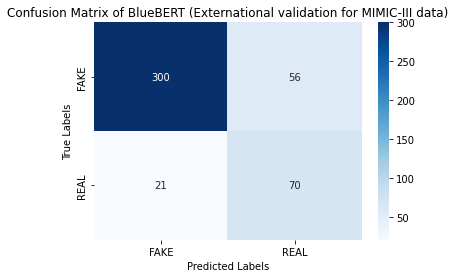

In [73]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT (Externational validation for MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT')

### Grid search of BlueBERT for optimization

In [74]:
# # %%time
# # from bert import run_classifier
# params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# # wrap classifier/regressor in GridSearchCV
# clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
#                    params,
#                    cv=3,
#                    scoring='accuracy',
#                    verbose=True)

# # fit gridsearch 
# clf_bert.fit(X_train ,y_train)

In [75]:
# means = clf_bert.cv_results_['mean_test_score']
# stds = clf_bert.cv_results_['std_test_score']

# for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
        
# # best scores
# print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

In [76]:
#define a batch size
batch_size = 5
epochs = 75
learning_rate = 1e-5

In [77]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [78]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 75


100%|██████████| 161/161 [00:05<00:00, 29.42it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.43it/s]


Training Loss: 0.685 dev performance, p:0.396, r:0.671, f1:0.498
current best score is 0.498

 Epoch 2 / 75



100%|██████████| 161/161 [00:05<00:00, 29.25it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.16it/s]


Training Loss: 0.677 dev performance, p:0.455, r:0.622, f1:0.526
current best score is 0.526

 Epoch 3 / 75



100%|██████████| 161/161 [00:05<00:00, 29.26it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.36it/s]


Training Loss: 0.671 dev performance, p:0.484, r:0.744, f1:0.587
current best score is 0.587

 Epoch 4 / 75



100%|██████████| 161/161 [00:05<00:00, 29.42it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.69it/s]


Training Loss: 0.666 dev performance, p:0.602, r:0.720, f1:0.656
current best score is 0.656

 Epoch 5 / 75



100%|██████████| 161/161 [00:05<00:00, 29.34it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.28it/s]


Training Loss: 0.658 dev performance, p:0.626, r:0.756, f1:0.685
current best score is 0.685

 Epoch 6 / 75



100%|██████████| 161/161 [00:05<00:00, 28.54it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 91.34it/s]


Training Loss: 0.655 dev performance, p:0.674, r:0.732, f1:0.702
current best score is 0.702

 Epoch 7 / 75



100%|██████████| 161/161 [00:06<00:00, 26.31it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.51it/s]


Training Loss: 0.648 dev performance, p:0.802, r:0.793, f1:0.798
current best score is 0.798

 Epoch 8 / 75



100%|██████████| 161/161 [00:05<00:00, 29.38it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.09it/s]


Training Loss: 0.642 dev performance, p:0.863, r:0.768, f1:0.813
current best score is 0.813

 Epoch 9 / 75



100%|██████████| 161/161 [00:05<00:00, 29.34it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.31it/s]


Training Loss: 0.637 dev performance, p:0.878, r:0.793, f1:0.833
current best score is 0.833

 Epoch 10 / 75



100%|██████████| 161/161 [00:05<00:00, 29.24it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.63it/s]


Training Loss: 0.631 dev performance, p:0.921, r:0.854, f1:0.886
current best score is 0.886

 Epoch 11 / 75



100%|██████████| 161/161 [00:05<00:00, 29.44it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.17it/s]


Training Loss: 0.626 dev performance, p:0.946, r:0.854, f1:0.897
current best score is 0.897

 Epoch 12 / 75



100%|██████████| 161/161 [00:05<00:00, 29.34it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.88it/s]


Training Loss: 0.620 dev performance, p:0.947, r:0.866, f1:0.904
current best score is 0.904

 Epoch 13 / 75



100%|██████████| 161/161 [00:05<00:00, 29.41it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.53it/s]


Training Loss: 0.612 dev performance, p:0.927, r:0.927, f1:0.927
current best score is 0.927

 Epoch 14 / 75



100%|██████████| 161/161 [00:05<00:00, 29.18it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.57it/s]


Training Loss: 0.612 dev performance, p:0.949, r:0.915, f1:0.932
current best score is 0.932

 Epoch 15 / 75



100%|██████████| 161/161 [00:05<00:00, 29.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.35it/s]


Training Loss: 0.604 dev performance, p:0.950, r:0.927, f1:0.938
current best score is 0.938

 Epoch 16 / 75



100%|██████████| 161/161 [00:05<00:00, 28.98it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.97it/s]


Training Loss: 0.599 dev performance, p:0.961, r:0.902, f1:0.931

 Epoch 17 / 75



100%|██████████| 161/161 [00:05<00:00, 29.05it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.73it/s]


Training Loss: 0.591 dev performance, p:0.962, r:0.927, f1:0.944
current best score is 0.944

 Epoch 18 / 75



100%|██████████| 161/161 [00:05<00:00, 29.34it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.42it/s]


Training Loss: 0.586 dev performance, p:0.963, r:0.939, f1:0.951
current best score is 0.951

 Epoch 19 / 75



100%|██████████| 161/161 [00:05<00:00, 29.15it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.58it/s]


Training Loss: 0.585 dev performance, p:0.962, r:0.927, f1:0.944

 Epoch 20 / 75



100%|██████████| 161/161 [00:05<00:00, 29.00it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.32it/s]


Training Loss: 0.576 dev performance, p:0.951, r:0.951, f1:0.951
current best score is 0.951

 Epoch 21 / 75



100%|██████████| 161/161 [00:05<00:00, 29.08it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.18it/s]


Training Loss: 0.571 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 22 / 75



100%|██████████| 161/161 [00:05<00:00, 29.15it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.26it/s]


Training Loss: 0.568 dev performance, p:0.962, r:0.927, f1:0.944

 Epoch 23 / 75



100%|██████████| 161/161 [00:05<00:00, 28.27it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.96it/s]


Training Loss: 0.562 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 24 / 75



100%|██████████| 161/161 [00:06<00:00, 24.88it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 89.40it/s]


Training Loss: 0.556 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 25 / 75



100%|██████████| 161/161 [00:05<00:00, 28.16it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.57it/s]


Training Loss: 0.553 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 26 / 75



100%|██████████| 161/161 [00:06<00:00, 26.72it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.89it/s]


Training Loss: 0.545 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 27 / 75



100%|██████████| 161/161 [00:05<00:00, 29.17it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.17it/s]


Training Loss: 0.541 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 28 / 75



100%|██████████| 161/161 [00:05<00:00, 29.17it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.03it/s]


Training Loss: 0.535 dev performance, p:0.963, r:0.951, f1:0.957


current best score is 0.957

 Epoch 29 / 75


100%|██████████| 161/161 [00:06<00:00, 25.38it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.69it/s]


Training Loss: 0.532 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 30 / 75



100%|██████████| 161/161 [00:05<00:00, 29.43it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.82it/s]


Training Loss: 0.530 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 31 / 75



100%|██████████| 161/161 [00:06<00:00, 26.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 88.38it/s]


Training Loss: 0.525 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 32 / 75



100%|██████████| 161/161 [00:06<00:00, 24.48it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 86.96it/s]


Training Loss: 0.518 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 33 / 75



100%|██████████| 161/161 [00:06<00:00, 24.01it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 88.19it/s]


Training Loss: 0.515 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 34 / 75



100%|██████████| 161/161 [00:06<00:00, 26.76it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 86.80it/s]


Training Loss: 0.510 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 35 / 75



100%|██████████| 161/161 [00:05<00:00, 27.88it/s]


evaluating...


100%|██████████| 54/54 [00:00<00:00, 114.28it/s]


Training Loss: 0.505 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 36 / 75



100%|██████████| 161/161 [00:05<00:00, 28.16it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 106.84it/s]


Training Loss: 0.499 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 37 / 75



100%|██████████| 161/161 [00:05<00:00, 28.31it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 90.22it/s]


Training Loss: 0.497 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 38 / 75



100%|██████████| 161/161 [00:06<00:00, 25.52it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.94it/s]


Training Loss: 0.492 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 39 / 75



100%|██████████| 161/161 [00:05<00:00, 29.25it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.19it/s]


Training Loss: 0.486 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 40 / 75



100%|██████████| 161/161 [00:05<00:00, 29.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 113.90it/s]


Training Loss: 0.484 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 41 / 75



100%|██████████| 161/161 [00:05<00:00, 29.39it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.16it/s]


Training Loss: 0.481 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 42 / 75



100%|██████████| 161/161 [00:05<00:00, 29.40it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.26it/s]


Training Loss: 0.474 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 43 / 75



100%|██████████| 161/161 [00:06<00:00, 24.68it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 117.48it/s]


Training Loss: 0.473 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 44 / 75



100%|██████████| 161/161 [00:05<00:00, 28.61it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.44it/s]


Training Loss: 0.470 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 45 / 75



100%|██████████| 161/161 [00:05<00:00, 28.26it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.09it/s]


Training Loss: 0.463 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 46 / 75



100%|██████████| 161/161 [00:05<00:00, 29.37it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.56it/s]


Training Loss: 0.459 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 47 / 75



100%|██████████| 161/161 [00:06<00:00, 26.56it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.90it/s]


Training Loss: 0.456 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 48 / 75



100%|██████████| 161/161 [00:06<00:00, 26.36it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.73it/s]


Training Loss: 0.453 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 49 / 75



100%|██████████| 161/161 [00:05<00:00, 27.13it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.25it/s]


Training Loss: 0.448 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 50 / 75



100%|██████████| 161/161 [00:05<00:00, 29.28it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.30it/s]


Training Loss: 0.443 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 51 / 75



100%|██████████| 161/161 [00:05<00:00, 28.41it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.79it/s]


Training Loss: 0.440 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 52 / 75



100%|██████████| 161/161 [00:05<00:00, 29.38it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.05it/s]


Training Loss: 0.436 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 53 / 75



100%|██████████| 161/161 [00:05<00:00, 27.00it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.73it/s]


Training Loss: 0.433 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 54 / 75



100%|██████████| 161/161 [00:06<00:00, 26.65it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.77it/s]


Training Loss: 0.430 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 55 / 75



100%|██████████| 161/161 [00:06<00:00, 26.61it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.82it/s]


Training Loss: 0.425 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 56 / 75



100%|██████████| 161/161 [00:06<00:00, 26.44it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.69it/s]


Training Loss: 0.423 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 57 / 75



100%|██████████| 161/161 [00:06<00:00, 26.28it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 109.48it/s]


Training Loss: 0.418 dev performance, p:0.963, r:0.939, f1:0.951

 Epoch 58 / 75



100%|██████████| 161/161 [00:06<00:00, 26.10it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.75it/s]


Training Loss: 0.418 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 59 / 75



100%|██████████| 161/161 [00:07<00:00, 22.51it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.73it/s]


Training Loss: 0.412 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 60 / 75



100%|██████████| 161/161 [00:06<00:00, 26.51it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 110.54it/s]


Training Loss: 0.408 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 61 / 75



100%|██████████| 161/161 [00:06<00:00, 26.41it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.16it/s]


Training Loss: 0.406 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 62 / 75



100%|██████████| 161/161 [00:06<00:00, 26.54it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.65it/s]


Training Loss: 0.402 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 63 / 75



100%|██████████| 161/161 [00:06<00:00, 26.50it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.46it/s]


Training Loss: 0.398 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 64 / 75



100%|██████████| 161/161 [00:06<00:00, 26.63it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.44it/s]


Training Loss: 0.395 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 65 / 75



100%|██████████| 161/161 [00:06<00:00, 26.53it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 114.36it/s]


Training Loss: 0.391 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 66 / 75



100%|██████████| 161/161 [00:06<00:00, 26.56it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 108.32it/s]


Training Loss: 0.389 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 67 / 75



100%|██████████| 161/161 [00:06<00:00, 25.52it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.41it/s]


Training Loss: 0.385 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 68 / 75



100%|██████████| 161/161 [00:06<00:00, 26.71it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.55it/s]


Training Loss: 0.381 dev performance, p:0.963, r:0.951, f1:0.957

 Epoch 69 / 75



100%|██████████| 161/161 [00:06<00:00, 26.66it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.26it/s]


Training Loss: 0.378 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 70 / 75



100%|██████████| 161/161 [00:06<00:00, 26.56it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 112.33it/s]


Training Loss: 0.374 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 71 / 75



100%|██████████| 161/161 [00:06<00:00, 26.66it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 115.85it/s]


Training Loss: 0.371 dev performance, p:0.951, r:0.939, f1:0.945

 Epoch 72 / 75



100%|██████████| 161/161 [00:06<00:00, 26.52it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.06it/s]


Training Loss: 0.369 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 73 / 75



100%|██████████| 161/161 [00:06<00:00, 26.55it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.43it/s]


Training Loss: 0.367 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 74 / 75



100%|██████████| 161/161 [00:06<00:00, 26.58it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 116.16it/s]


Training Loss: 0.364 dev performance, p:0.951, r:0.951, f1:0.951

 Epoch 75 / 75



100%|██████████| 161/161 [00:06<00:00, 26.66it/s]

evaluating...



100%|██████████| 54/54 [00:00<00:00, 111.66it/s]


Training Loss: 0.361 dev performance, p:0.963, r:0.951, f1:0.957


In [79]:
model_file = 'bluebert_gridsearch_meh_validation.pt'
torch.save(best_model_state, model_file)

In [80]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_gridsearch_meh_validation.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BlueBERT

In [81]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [82]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 90/90 [00:00<00:00, 114.01it/s]

{'precision': 0.934375, 'recall': 0.8398876404494382, 'f1': 0.8846153846153846}


In [83]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64        91
           1       0.93      0.84      0.88       356

    accuracy                           0.82       447
   macro avg       0.74      0.80      0.76       447
weighted avg       0.86      0.82      0.83       447



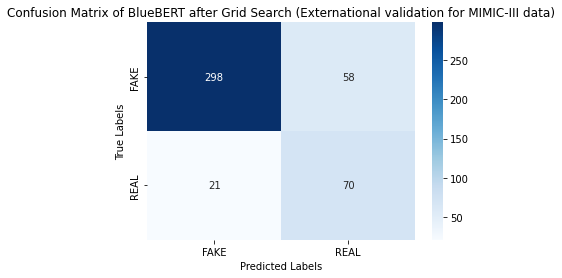

In [84]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT after Grid Search (Externational validation for MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT(grid search)')